# Analyze nuclear morphology of MDCK spheroids for figure 4b
Data: 
- Nucleus: reconstructed 3D blue channel images of MDCK spheroids
- Segmented spheroid: segmented images of spheroids

# Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from skimage.measure import regionprops_table, marching_cubes, mesh_surface_area
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage.filters import unsharp_mask

from cellpose import models, core
from cellpose import plot

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

2023-05-19 04:35:27,036 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
2023-05-19 04:35:27,039 [INFO] WRITING LOG OUTPUT TO /home/minato/.cellpose/run.log


## Functions

In [6]:
def segment(data, suffix):
    '''
    Segment nuclei

    data: name of the input data
    suffix: suffix of the input data
    '''
    res = []
    for s in suffix:
        print(s)
        img = np.load(f'../result/{data}{s}.npy')
        img = img[25:75, 10:630, 45:img.shape[2]-50]
        img = (img - img.min()) / (img.max() - img.min())
        img = unsharp_mask(img, radius=5, amount=10)

        model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
        channels = [0,0]
        masks, flows, styles, _ = model.eval(img, channels=channels, diameter=17, do_3D=True)
        res.append(masks)

    return res

In [2]:
def filter(nucleus, spheroid, suffix):
    '''
    Filter out nuclei in spheroids without beads

    nucleus: label images of nuclei after segmentation
    spheroid: name of the data of segmented spheroids
    suffix: suffix of the data of spheroid
    '''
    res_filtered = []
    for i, s in enumerate(suffix):
        spheroid = np.load(f'../result/{data}{s}_segmented_spheroids.npy')
        spheroid = spheroid>0 # select area of spheroids
        nucleus_i = nucleus[i][..., :spheroid.shape[2]] # adjust the size
        retained_labels = np.unique(nucleus_i[spheroid]) # find labels of nucleus inside spheroids
        res_filtered.append(np.where(np.isin(nucleus[i], retained_labels), nucleus[i], 0)) 

    return  res_filtered

In [1]:
def calculate_props(segmented, scale=(None, None, None)):
    '''
    Calculate morphological properties of nuclei

    segmented: label image after segmentation
    scale: pixel resolution in um scale
    '''
    res = []
    surface = []
    
    for data in segmented:
        data = clear_border(data) # remove objects on the edge
        data = remove_small_objects(data, min_size=125)  # remove small objects
        props = pd.DataFrame(regionprops_table(data, properties=('label', 'area', 'axis_major_length', 'axis_minor_length', 'solidity', 'bbox'),
                                           spacing=scale))

        # calculate properties
        props = props.rename(columns={'area': 'Volume', 'axis_major_length': 'Major axis length', 'axis_minor_length': 'Minor axis length', 'solidity': 'Solidity'})
        props['Aspect ratio'] = props['Major axis length']/props['Minor axis length']
        res.append(props)
        
        for i, row in props.iterrows():
            label = row['label']
            bbox = np.array((row['bbox-0'], row['bbox-3'], row['bbox-1'], row['bbox-4'], row['bbox-2'], row['bbox-5']), dtype='uint64')
            labelled_object = data[bbox[0]:bbox[1], bbox[2]:bbox[3], bbox[4]:bbox[5]]
            labelled_object = np.where(labelled_object==label, True, False)

            verts, faces, _, _ = marching_cubes(labelled_object, spacing=scale)
            surface.append(mesh_surface_area(verts, faces))
        
    res = pd.concat(res)
    res = res.reset_index(drop=True)
    res['label'] = np.arange(1, len(res)+1)
    
    res['Surface area'] = surface
    res['Surface-to-Volume'] = surface/res['Volume']
    
    return res

## Parameters

In [4]:
suffix = ['', '_X1', '_X2', '_X3', '_X4', '_X5', '_X6']
scale = np.repeat(0.295*4, 3) # spatial resolution in um scale

NameError: name 'np' is not defined

## Analysis

### Measurement: 1

In [5]:
data = 'id551_MDCK_unit_on_on_01_300Hz_405_250mW_488_150mW_405'

In [10]:
res = segment(data, suffix)


2023-05-19 04:35:48,717 [INFO] ** TORCH CUDA version installed and working. **
2023-05-19 04:35:48,720 [INFO] >>>> using GPU
2023-05-19 04:35:48,723 [INFO] >> nuclei << model set to be used
2023-05-19 04:35:49,218 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-05-19 04:35:49,225 [INFO] ~~~ FINDING MASKS ~~~
2023-05-19 04:35:49,513 [INFO] multi-stack tiff read in as having 50 planes 1 channels
2023-05-19 04:36:05,067 [INFO] running YX: 50 planes of size (620, 2688)
2023-05-19 04:36:46,528 [INFO] 100%|##########| 50/50 [00:40<00:00,  1.23it/s]
2023-05-19 04:36:53,137 [INFO] running ZY: 620 planes of size (50, 2688)
2023-05-19 04:37:34,838 [INFO] 100%|##########| 310/310 [00:40<00:00,  7.67it/s]
2023-05-19 04:37:46,569 [INFO] running ZX: 2688 planes of size (50, 620)
2023-05-19 04:38:34,625 [INFO] 100%|##########| 336/336 [00:46<00:00,  7.24it/s]
2023-05-19 04:38:45,544 [INFO] network run in 174.22s
2023-05-19 04:39:30,533 [INFO] masks created in 

In [11]:
for i in res:
    print(np.unique(i))

[   0    1    2 ... 2420 2421 2422]
[   0    1    2 ... 5129 5130 5131]
[   0    1    2 ... 6327 6328 6329]
[   0    1    2 ... 3542 3543 3544]
[   0    1    2 ... 4181 4182 4183]
[   0    1    2 ... 3877 3878 3879]
[   0    1    2 ... 1780 1781 1782]


In [16]:
res_filtered = filter(res, 'id551_MDCK_unit_on_on_01_300Hz_405_250mW_488_150mW_488', suffix)

In [17]:
for i in res_filtered:
    print(len(np.unique(i)))

681
1413
2316
925
1083
834
358


In [18]:
print(np.sum([len(np.unique(i)) for i in res_filtered]))

7610


In [20]:
res_props = calculate_props(res_filtered, scale=scale)

In [21]:
res_props

,label,Volume,Major axis length,Minor axis length,Solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,Aspect ratio,Surface area,Surface-to-Volume
0,1,732.792272,17.522566,8.691061,0.706815,5,36,666,15,45,680,2.016160,474.917394,0.648093
1,2,366.396136,11.411533,7.030594,0.844697,5,381,416,14,388,424,1.623125,194.003265,0.529490
2,3,333.535496,11.687440,7.529344,0.609610,6,237,934,12,245,945,1.552252,255.040730,0.764658
3,4,520.841144,14.852935,9.073934,0.630219,6,237,936,18,245,946,1.636879,391.418858,0.751513
4,5,205.379000,25.592393,6.189372,0.176803,6,302,1059,22,315,1075,4.134894,409.132215,1.992084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,5123,294.102728,11.786578,6.483229,0.817352,36,469,866,43,478,872,1.818010,154.707366,0.526032
5123,5124,264.528152,9.841110,6.483748,0.834197,37,159,353,44,167,359,1.517812,139.383424,0.526913
5124,5125,238.239640,8.533528,7.148843,0.847953,37,164,361,44,171,368,1.193694,157.282318,0.660185
5125,5126,586.562424,17.489523,7.069050,0.791574,38,113,822,44,121,836,2.474098,285.349536,0.486478


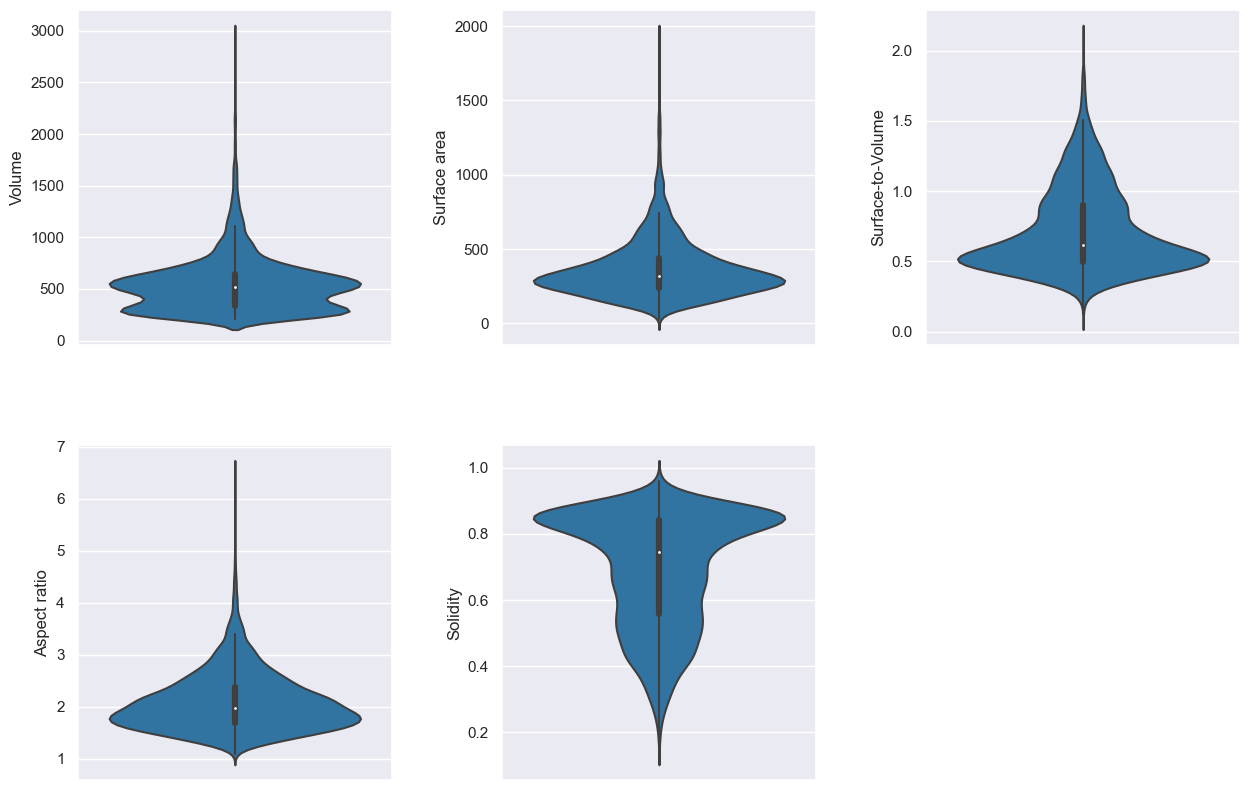

In [22]:
sns.set_style('darkgrid')
sns.set_context('notebook')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns = ['Volume', 'Surface area', 'Surface-to-Volume', 'Aspect ratio', 'Solidity']

for i, ax in enumerate(axes):
    if i == 5:
        axes[i].set_axis_off()
    else:
        sns.violinplot(data=res_props, y=columns[i], ax=ax)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
#plt.suptitle(f'Morphological properties of nucleus n={n_adhered}(adhered), {n_suspended}(suspended)', y=0.95, size=20)

In [23]:
res_props.to_csv('../result/spheroid_on_on_1_props.csv')

### Measurement: 2

In [ ]:
data = 'id551_MDCK_unit_on_on_02_300Hz_405_250mW_488_150mW_405'

In [10]:
res = segment(data, suffix)


2023-05-19 04:35:48,717 [INFO] ** TORCH CUDA version installed and working. **
2023-05-19 04:35:48,720 [INFO] >>>> using GPU
2023-05-19 04:35:48,723 [INFO] >> nuclei << model set to be used
2023-05-19 04:35:49,218 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-05-19 04:35:49,225 [INFO] ~~~ FINDING MASKS ~~~
2023-05-19 04:35:49,513 [INFO] multi-stack tiff read in as having 50 planes 1 channels
2023-05-19 04:36:05,067 [INFO] running YX: 50 planes of size (620, 2688)
2023-05-19 04:36:46,528 [INFO] 100%|##########| 50/50 [00:40<00:00,  1.23it/s]
2023-05-19 04:36:53,137 [INFO] running ZY: 620 planes of size (50, 2688)
2023-05-19 04:37:34,838 [INFO] 100%|##########| 310/310 [00:40<00:00,  7.67it/s]
2023-05-19 04:37:46,569 [INFO] running ZX: 2688 planes of size (50, 620)
2023-05-19 04:38:34,625 [INFO] 100%|##########| 336/336 [00:46<00:00,  7.24it/s]
2023-05-19 04:38:45,544 [INFO] network run in 174.22s
2023-05-19 04:39:30,533 [INFO] masks created in 

In [11]:
for i in res:
    print(np.unique(i))

[   0    1    2 ... 2420 2421 2422]
[   0    1    2 ... 5129 5130 5131]
[   0    1    2 ... 6327 6328 6329]
[   0    1    2 ... 3542 3543 3544]
[   0    1    2 ... 4181 4182 4183]
[   0    1    2 ... 3877 3878 3879]
[   0    1    2 ... 1780 1781 1782]


In [16]:
res_filtered = filter(res, 'id551_MDCK_unit_on_on_02_300Hz_405_250mW_488_150mW_488', suffix)

In [17]:
for i in res_filtered:
    print(len(np.unique(i)))

681
1413
2316
925
1083
834
358


In [18]:
print(np.sum([len(np.unique(i)) for i in res_filtered]))

7610


In [20]:
res_props = calculate_props(res_filtered, scale=scale)

In [21]:
res_props

,label,Volume,Major axis length,Minor axis length,Solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,Aspect ratio,Surface area,Surface-to-Volume
0,1,732.792272,17.522566,8.691061,0.706815,5,36,666,15,45,680,2.016160,474.917394,0.648093
1,2,366.396136,11.411533,7.030594,0.844697,5,381,416,14,388,424,1.623125,194.003265,0.529490
2,3,333.535496,11.687440,7.529344,0.609610,6,237,934,12,245,945,1.552252,255.040730,0.764658
3,4,520.841144,14.852935,9.073934,0.630219,6,237,936,18,245,946,1.636879,391.418858,0.751513
4,5,205.379000,25.592393,6.189372,0.176803,6,302,1059,22,315,1075,4.134894,409.132215,1.992084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5122,5123,294.102728,11.786578,6.483229,0.817352,36,469,866,43,478,872,1.818010,154.707366,0.526032
5123,5124,264.528152,9.841110,6.483748,0.834197,37,159,353,44,167,359,1.517812,139.383424,0.526913
5124,5125,238.239640,8.533528,7.148843,0.847953,37,164,361,44,171,368,1.193694,157.282318,0.660185
5125,5126,586.562424,17.489523,7.069050,0.791574,38,113,822,44,121,836,2.474098,285.349536,0.486478


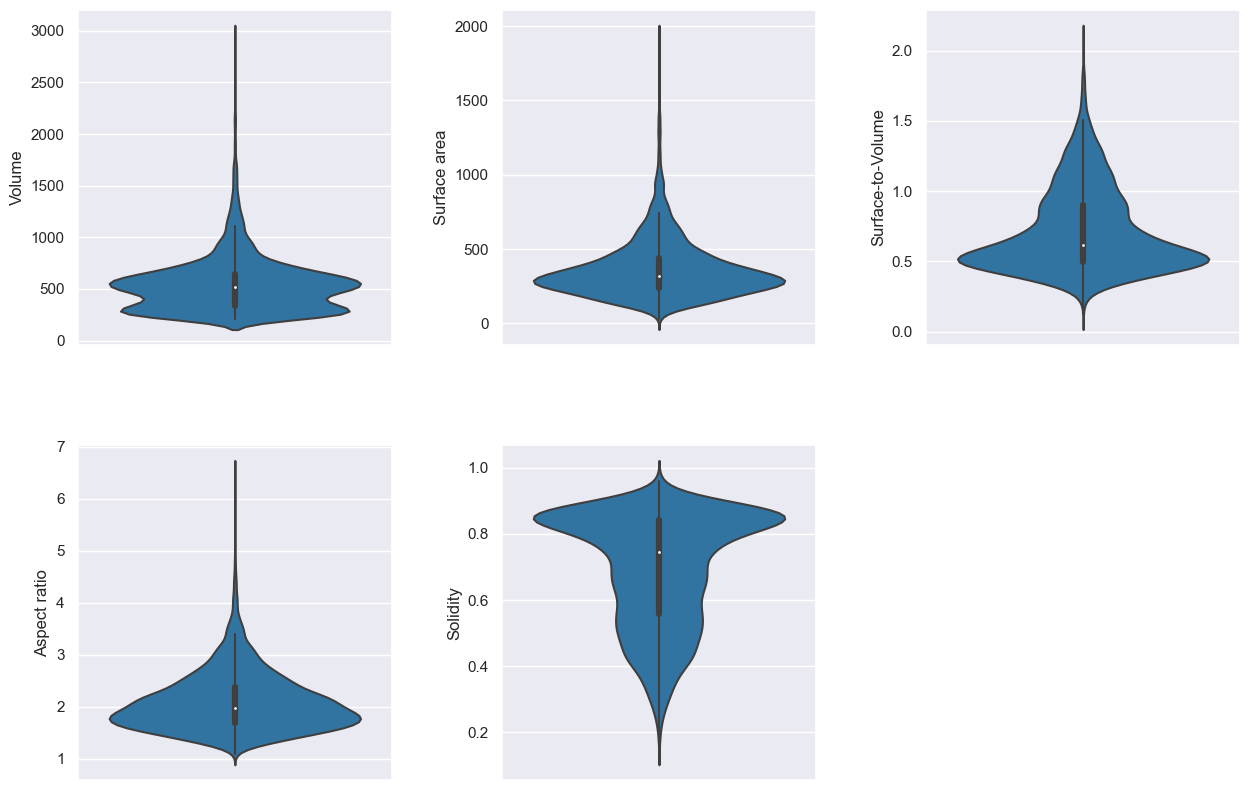

In [22]:
sns.set_style('darkgrid')
sns.set_context('notebook')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns = ['Volume', 'Surface area', 'Surface-to-Volume', 'Aspect ratio', 'Solidity']

for i, ax in enumerate(axes):
    if i == 5:
        axes[i].set_axis_off()
    else:
        sns.violinplot(data=res_props, y=columns[i], ax=ax)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
#plt.suptitle(f'Morphological properties of nucleus n={n_adhered}(adhered), {n_suspended}(suspended)', y=0.95, size=20)

In [23]:
res_props.to_csv('../result/spheroid_on_on_2_props.csv')

### Measurement: 3

In [24]:
data = 'id551_MDCK_unit_on_on_03_300Hz_405_250mW_488_150mW_405'

In [25]:
res = segment(data, suffix)


2023-05-19 09:46:35,191 [INFO] ** TORCH CUDA version installed and working. **
2023-05-19 09:46:35,192 [INFO] >>>> using GPU
2023-05-19 09:46:35,193 [INFO] >> nuclei << model set to be used
2023-05-19 09:46:35,341 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-05-19 09:46:35,342 [INFO] ~~~ FINDING MASKS ~~~
2023-05-19 09:46:35,406 [INFO] multi-stack tiff read in as having 50 planes 1 channels
2023-05-19 09:46:42,143 [INFO] running YX: 50 planes of size (620, 2723)
2023-05-19 09:47:13,454 [INFO] 100%|##########| 50/50 [00:30<00:00,  1.62it/s]
2023-05-19 09:47:16,552 [INFO] running ZY: 620 planes of size (50, 2723)
2023-05-19 09:47:50,648 [INFO] 100%|##########| 310/310 [00:33<00:00,  9.26it/s]
2023-05-19 09:47:55,271 [INFO] running ZX: 2723 planes of size (50, 620)
2023-05-19 09:48:36,207 [INFO] 100%|##########| 341/341 [00:40<00:00,  8.47it/s]
2023-05-19 09:48:42,223 [INFO] network run in 126.00s
2023-05-19 09:49:29,531 [INFO] masks created in 

In [26]:
for i in res:
    print(np.unique(i))

[   0    1    2 ... 3105 3106 3107]
[   0    1    2 ... 5491 5492 5493]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228

In [27]:
res_filtered = filter(res, 'id551_MDCK_unit_on_on_03_300Hz_405_250mW_488_150mW_488', suffix)

In [28]:
for i in res_filtered:
    print(len(np.unique(i)))

770
1268
84
10
6
40
268


In [29]:
print(np.sum([len(np.unique(i)) for i in res_filtered]))

2446


In [31]:
res_props = calculate_props(res_filtered, scale=scale)

In [32]:
res_props

,label,Volume,Major axis length,Minor axis length,Solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,Aspect ratio,Surface area,Surface-to-Volume
0,1,524.127208,16.916223,6.968400,0.839474,3,455,1307,16,461,1315,2.427562,229.076920,0.437064
1,2,543.843592,13.534441,8.049297,0.859740,4,70,864,14,77,872,1.681444,208.078234,0.382607
2,3,440.332576,12.897383,6.778840,0.795252,5,53,231,15,63,237,1.902595,233.923196,0.531242
3,4,650.640672,16.018797,7.585974,0.828452,5,63,316,16,71,327,2.111634,317.478254,0.487947
4,5,458.405928,11.365508,8.363417,0.897106,5,69,1960,12,76,1969,1.358955,144.956339,0.316218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,1655,359.824008,15.637125,5.491536,0.776596,35,176,220,45,183,230,2.847495,235.210354,0.653682
1655,1656,596.420616,13.656268,8.710250,0.850117,35,244,1142,42,253,1153,1.567839,254.563907,0.426819
1656,1657,933.242176,19.479946,9.848698,0.647662,37,158,786,46,171,802,1.977921,540.945667,0.579641
1657,1658,345.036720,11.495979,7.209577,0.786517,37,167,216,44,175,226,1.594543,225.134459,0.652494


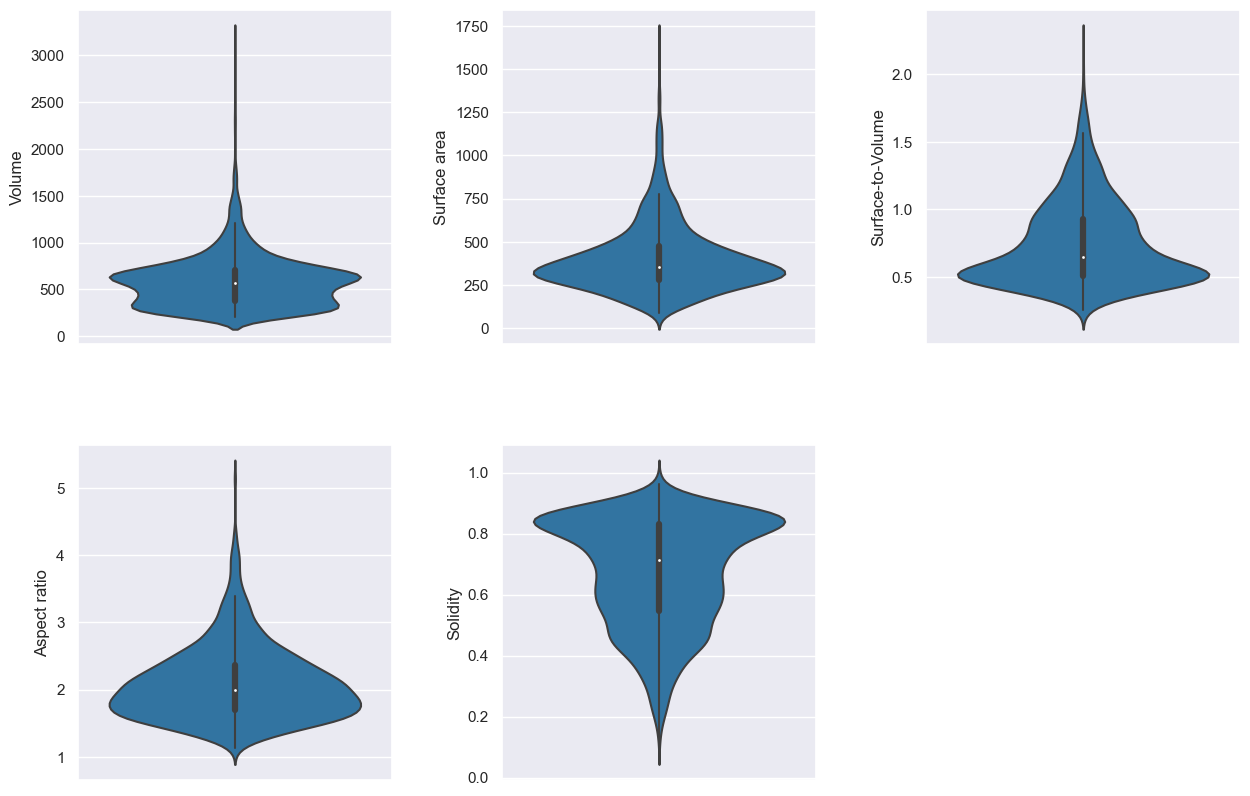

In [33]:
sns.set_style('darkgrid')
sns.set_context('notebook')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns = ['Volume', 'Surface area', 'Surface-to-Volume', 'Aspect ratio', 'Solidity']

for i, ax in enumerate(axes):
    if i == 5:
        axes[i].set_axis_off()
    else:
        sns.violinplot(data=res_props, y=columns[i], ax=ax)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
#plt.suptitle(f'Morphological properties of nucleus n={n_adhered}(adhered), {n_suspended}(suspended)', y=0.95, size=20)

In [34]:
res_props.to_csv('../result/spheroid_on_on_3_props.csv')